In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import sys

sys.path.append('..')

from algorithms.random_policy import RandomPolicy
from algorithms.sequence_models.decision_sequence_policy import DTPolicy
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.evaluate import evaluate_on_env
from data.door_key_dataset import DoorKeyDataset
from data.random_walk_dataset import RandomWalkDataset
from envs.door_key import DoorKeyEnv, DoorKeyEnvSmall
from data.trajectory import LimitedContextWrapper
from algorithms.sequence_models.config import TrainConfig
from algorithms.sequence_models.decision_transformer.trainer import TrainerDT
from envs.random_walk import RandomWalkEnv
from experiment import Experiment
import gymnasium as gym
from functools import partial
from algorithms.evaluate_policy import evaluate_policy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is ", device)

device is  cuda


In [4]:
from minigrid.wrappers import ImgObsWrapper

inner_env = gym.make('MiniGrid-DoorKey-5x5-v0')
inner_env_human = gym.make('MiniGrid-DoorKey-5x5-v0', render_mode='human')
env = ImgObsWrapper(inner_env)
env_human = ImgObsWrapper(inner_env_human)


config = TrainConfig(max_eval_ep_len=env.max_steps, context_len=32,
                     eval_model_interval=50)

#################### todo
# n_trajectories should be at least 10000 for the agent to learn I think 
####################
n_trajectories = 10_000
experiment_name = f"experiment_door_key_dataset_size={n_trajectories}"
# if DoorKeyDataset.exists(experiment_name):
#     traj_dataset = DoorKeyDataset.load(experiment_name)
# else:
traj_dataset = DoorKeyDataset(env, n_trajectories=n_trajectories, reward_scale=1, prob_keeping_nonzero=0.01)
traj_dataset.save(experiment_name)

dt_model = DecisionTransformer(
    state_dim=traj_dataset.state_dim(),
    act_dim=traj_dataset.action_dim(),
    n_blocks=config.n_blocks,
    h_dim=config.embed_dim,
    context_len=config.context_len,
    n_heads=config.n_heads,
    drop_p=config.dropout_p,
).to(device)

make_dt_policy = partial(DTPolicy, model=dt_model, traj_dataset=traj_dataset, device=device, max_test_ep_len=config.max_eval_ep_len, context_length=config.context_len)

experiment = Experiment(
    model_name='dt',
    model=dt_model,
    env_name='MiniGrid-DoorKey-5x5-v0',
    env=env,
    experiment_name='generalization',
    traj_dataset=traj_dataset,
    dataset_name=f'size={len(traj_dataset)}',
    config=config,
    device=device,
    eval_policies_and_names=[
        (make_dt_policy(rtg=rtg), f'dt,rtg={rtg}')
        for rtg in np.linspace(0, 1.5, 10)
    ]
)

collecting trajectories:   0%|          | 0/10000 [00:00<?, ?it/s]

Dataset Info:
episode_max_length: 250
reward_scale: 1
return min=0.0, max=0.9244 mean=0.3552352570828961
gamma: 1
number of parameters 1159579


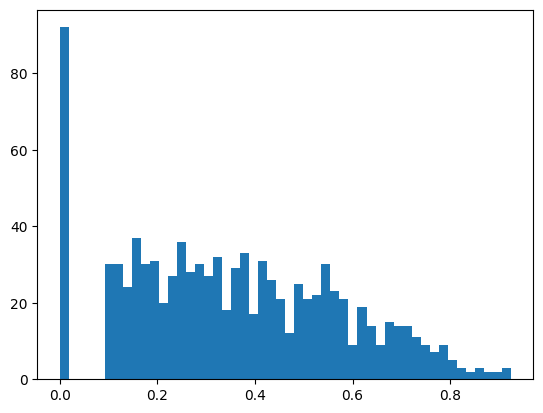

In [5]:
# rewards:
plt.hist([traj.returns[0] for traj in traj_dataset], bins=50);

In [ ]:
report = experiment.train_for(200)

training started


  0%|          | 0/200 [00:00<?, ?it/s]

time elapsed: 0:00:01
num of updates: 1100
loss: 0.12330
lr 0.00011
grad_norm 0.11059
time elapsed: 0:00:03
num of updates: 1200
loss: 0.12315
lr 0.00012
grad_norm 0.19603
time elapsed: 0:00:04
num of updates: 1300
loss: 0.12304
lr 0.00013
grad_norm 0.10123
time elapsed: 0:00:05
num of updates: 1400
loss: 0.12289
lr 0.00014
grad_norm 0.13275
time elapsed: 0:00:06
num of updates: 1500
loss: 0.12275
lr 0.00015
grad_norm 0.10654
time elapsed: 0:00:07
num of updates: 1600
loss: 0.12271
lr 0.00016
grad_norm 0.09943
time elapsed: 0:00:08
num of updates: 1700
loss: 0.12266
lr 0.00017
grad_norm 0.14555
time elapsed: 0:00:10
num of updates: 1800
loss: 0.12266
lr 0.00018
grad_norm 0.11927
time elapsed: 0:00:11
num of updates: 1900
loss: 0.12267
lr 0.00019
grad_norm 0.12240
time elapsed: 0:00:12
num of updates: 2000
loss: 0.12260
lr 0.00020
grad_norm 0.13757
time elapsed: 0:00:13
num of updates: 2100
loss: 0.12259
lr 0.00021
grad_norm 0.10511
time elapsed: 0:00:14
num of updates: 2200
loss: 0.122

<Axes: >

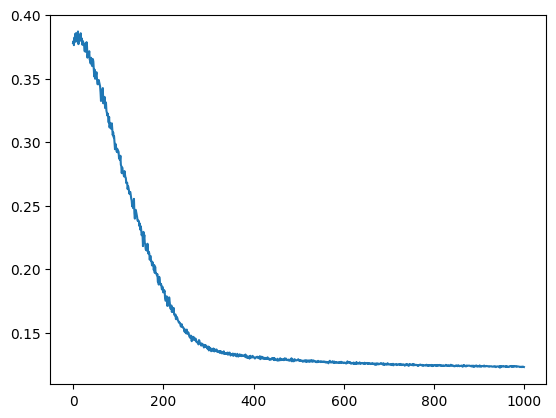

In [7]:
experiment.plot_loss(report)

In [8]:
# policy = RandomPolicy(env)
policy = make_dt_policy(rtg=1)

# you can also write another eval to store all the results not just the average
evaluate_policy(policy, env, num_eval_ep=2)

{'eval/avg_reward': 0.0, 'eval/avg_ep_len': 250.0}

In [29]:
# wanna see what's happening? use env_human

# you can also write another eval to store all the results not just the average
evaluate_policy(policy, env_human, num_eval_ep=1)

KeyboardInterrupt: 